- just check how it works and what's the output. 

Q: can you only do one chromosome at a time?
A: yes, you can provide chrom_subset

In [ ]:
import torch
import pandas as pd

from dlem.dlem_genome import dlem_notebook

cooler_file = '/Users/tina/LoopExtrusion/data/H1.mcool'
output_path = f'/Users/tina/LoopExtrusion/results/chr10_test.tsv'
resolution = 10_000
window_size = 200
stride = 50
dev_name ='cpu'



In [ ]:
df_result = dlem_notebook(cooler_file, output_path, resolution, 
                          model_name="minimal_dlem", window_size=window_size, stride=stride,
                          chrom_subset=['chr10'], perc_nan_threshold=0.3, lr=0.5, 
                          reader_name='datareader_cooler', dev_name=dev_name, do_return_result=True)

In [ ]:
# if you already ran it, do instead:
df_result = pd.read_csv('/Users/tina/LoopExtrusion/results/chr10_test.tsv', sep='\t')


In [11]:
df_result 

,chrom,start,end,patch_i,max_corr,perc_nan,importance_weights,left,right,location_id,instance_id
0,chr10,0,10000,0,0.793973,0.02,0.98,1.000000,0.990000,0,1
1,chr10,10000,20000,0,0.793973,0.02,1.96,0.581865,0.990000,1,1
2,chr10,20000,30000,0,0.793973,0.02,2.94,0.413492,0.990000,2,1
3,chr10,30000,40000,0,0.793973,0.02,3.92,0.327341,0.990000,3,1
4,chr10,40000,50000,0,0.793973,0.02,4.90,0.281918,0.990000,4,1
...,...,...,...,...,...,...,...,...,...,...,...
52795,chr10,133450000,133460000,263,0.772863,0.00,5.00,0.990000,0.986033,13345,1
52796,chr10,133460000,133470000,263,0.772863,0.00,4.00,0.990000,1.000000,13346,1
52797,chr10,133470000,133480000,263,0.772863,0.00,3.00,0.990000,0.994332,13347,1
52798,chr10,133480000,133490000,263,0.772863,0.00,2.00,0.990000,1.000000,13348,1


In [14]:
import numpy as np


def process_dataframe(df_result):
    """
    Process the dataframe to create wide format with weighted means.
    
    Parameters:
    df_result: The input dataframe with columns chrom, start, end, patch_i, max_corr, 
               perc_nan, importance_weights, left, right
    
    Returns:
    DataFrame: Processed dataframe with weighted averages
    """
    # Create a location identifier based on unique start/end combinations
    df_result['location_id'] = df_result.groupby(['start', 'end']).ngroup()
    
    # Create instance_id for each row within a location group
    df_result['instance_id'] = df_result.groupby('location_id').cumcount() + 1
    
    # Define columns that should have multiple instances
    varying_columns = ['patch_i', 'max_corr', 'perc_nan', 'importance_weights', 'left', 'right']
    
    # Pivot to create wide format for varying columns
    wide_df = pd.pivot(
        index='location_id',
        columns='instance_id',
        values=varying_columns,
        data=df_result
    )
    
    # Flatten the column names
    wide_df.columns = [f'{col[0]}_{col[1]}' for col in wide_df.columns]
    
    # Add the constant columns (start, end, chrom)
    constant_df = df_result.drop_duplicates('location_id')[['location_id', 'start', 'end', 'chrom']]
    
    # Join the constant columns with the wide format
    final_df = pd.merge(constant_df, wide_df, on='location_id')
    
    # Identify importance_weights columns
    importance_weight_cols = [col for col in final_df.columns if 'importance_weights_' in col]
    
    # Replace NaN values with 0 in all importance_weights columns
    final_df[importance_weight_cols] = final_df[importance_weight_cols].fillna(0)
    
    # Calculate sum of importance weights
    final_df['sum_importance_weights'] = final_df[importance_weight_cols].sum(axis=1)
    
    # Create weighted columns for left
    weighted_left_cols = []
    for i in range(1, 5):
        left_col = f'left_{i}'
        weight_col = f'importance_weights_{i}'
        weighted_col = f'weighted_left_{i}'
        weighted_left_cols.append(weighted_col)
        
        # If left is NaN, set weighted value to 0
        final_df[weighted_col] = np.where(
            final_df[left_col].isna(),
            0,
            final_df[left_col] * final_df[weight_col]
        )
    
    # Create weighted columns for right
    weighted_right_cols = []
    for i in range(1, 5):
        right_col = f'right_{i}'
        weight_col = f'importance_weights_{i}'
        weighted_col = f'weighted_right_{i}'
        weighted_right_cols.append(weighted_col)
        
        # If right is NaN, set weighted value to 0
        final_df[weighted_col] = np.where(
            final_df[right_col].isna(),
            0,
            final_df[right_col] * final_df[weight_col]
        )
    
    # Calculate sum of weighted values
    final_df['weighted_left_sum'] = final_df[weighted_left_cols].sum(axis=1)
    final_df['weighted_right_sum'] = final_df[weighted_right_cols].sum(axis=1)
    
    # Calculate weighted averages
    final_df['weighted_avg_left'] = final_df.apply(
        lambda row: row['weighted_left_sum'] / row['sum_importance_weights'] 
                   if row['sum_importance_weights'] > 0 else 0, 
        axis=1
    )
    
    final_df['weighted_avg_right'] = final_df.apply(
        lambda row: row['weighted_right_sum'] / row['sum_importance_weights'] 
                   if row['sum_importance_weights'] > 0 else 0, 
        axis=1
    )
    
    # Drop location_id if not needed
    final_df = final_df.drop(columns=['location_id'])

    final_df = final_df.set_index('start')
    
    return final_df

# Example usage:
# final_processed_df = process_dataframe(df_result)
# print(final_processed_df.head())

In [15]:
final_df = process_dataframe(df_result)

# Check the results

## violin plot of correlations (contact_map, prediction)

 28%|██▊       | 186/660 [00:13<00:30, 15.37it/s]/var/folders/q_/53c1vbkn3md_lj10n20xvpjw0000gn/T/ipykernel_5998/1564946107.py:30: RuntimeWarning: divide by zero encountered in log
  prediction = diagonal_normalize(np.log(prediction ))
/var/folders/q_/53c1vbkn3md_lj10n20xvpjw0000gn/T/ipykernel_5998/1564946107.py:30: RuntimeWarning: divide by zero encountered in log
  prediction = diagonal_normalize(np.log(prediction ))
 28%|██▊       | 188/660 [00:13<00:30, 15.62it/s]/var/folders/q_/53c1vbkn3md_lj10n20xvpjw0000gn/T/ipykernel_5998/1564946107.py:30: RuntimeWarning: divide by zero encountered in log
  prediction = diagonal_normalize(np.log(prediction ))
/var/folders/q_/53c1vbkn3md_lj10n20xvpjw0000gn/T/ipykernel_5998/1564946107.py:30: RuntimeWarning: divide by zero encountered in log
  prediction = diagonal_normalize(np.log(prediction ))
 29%|██▉       | 190/660 [00:13<00:29, 15.88it/s]/var/folders/q_/53c1vbkn3md_lj10n20xvpjw0000gn/T/ipykernel_5998/1564946107.py:30: RuntimeWarning: divide 

<Axes: >

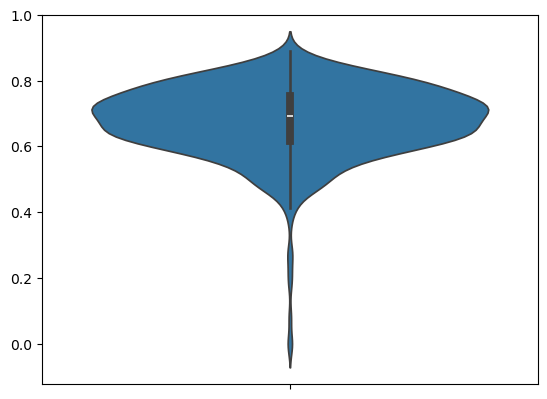

In [69]:

import matplotlib.pyplot as plt
import seaborn as sns


from dlem.readers.util import get_contact_map
from dlem.util import diagonal_normalize

from tqdm import tqdm

from dlem.loader import load_reader, load_model


reader_arch = load_reader('datareader_cooler')
data = reader_arch(cooler_file, resolution, window_size, 20, chrom_subset=['chr10'])

correlations = []

for i, (patch, _, _, start_i, end_i) in tqdm(enumerate(data), total=len(data)):    #len(data) ):


    hic = diagonal_normalize(np.log( patch[np.newaxis]) )[0]
    # plt.matshow(hic_map, cmap='vlag')

    L = np.array(final_df.loc[start_i:end_i-1]['weighted_avg_left'])  # -1, so it does not capture the next locus which is already out of bounds!
    R = np.array(final_df.loc[start_i:end_i-1]['weighted_avg_right'])

    plotting_model = load_model('minimal_dlem')(n=len(L), res=10_000, left_init=L, right_init=R)   # parameters

    prediction = plotting_model.contact_map_prediction(init_mass = torch.ones((1, len(L))))
    prediction = diagonal_normalize(np.log(prediction ))
    prediction  = prediction[0]

    if len(L) != len(hic):
         hic=hic[:len(L), :len(L)]   # for the end of the chromosome, prediction for the last few bins may not exist

    # now do correlation:
    flat_hic = hic.flatten()
    flat_pred = prediction.flatten()

    patch_correlation = np.corrcoef(flat_hic,flat_pred )[0,1]
    correlations.append(patch_correlation)

    # plt.matshow(prediction)
    '''
    dlem_vs_hic = np.triu(hic_map) + np.tril(prediction)

    plt.figure()
    plt.matshow(dlem_vs_hic, cmap='vlag')
    '''
    
    if i == len(data)-1:
         break
    
correlation = np.array(correlations)
sns.violinplot(correlation)

## visual inspection of selected patches

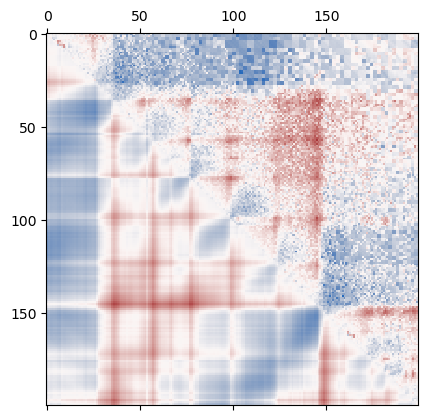

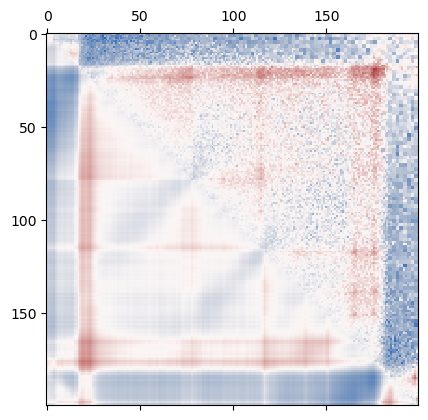

In [68]:
# look at a selection of patches from chr10

import matplotlib.pyplot as plt
import seaborn as sns


from dlem.readers.util import get_contact_map
from dlem.util import diagonal_normalize



def parse_locus_id(locus_id):
    """
    Parse a locus ID string in the format 'chr<num>:<start>-<end>'
    into its components: chromosome, start position, and end position.
    
    Args:
        locus_id (str): A string in the format 'chr<num>:<start>-<end>'
    
    Returns:
       chromosome, start_position, end_position
    """
    # Split the string by ':' to separate chromosome from positions
    chrom_part, pos_part = locus_id.split(':')
    
    # Split the positions by '-' to get start and end
    start, end = pos_part.split('-')
    
    # Convert start and end to integers
    start_pos = int(start)
    end_pos = int(end)
    
    return chrom_part, start_pos, end_pos


loci = ['chr10:20500000-22500000', 'chr10:3000000-5000000']

for locus in loci:
    chrom, start_loc, end_loc = parse_locus_id(locus)


    hic_map, _ = get_contact_map(cooler_file=cooler_file, resolution = resolution, chromosome = chrom, start = start_loc, end = end_loc)
    hic_map = diagonal_normalize(np.log( hic_map[np.newaxis]) )[0]
    # plt.matshow(hic_map, cmap='vlag')

    L = np.array(final_df.loc[start_loc:end_loc-1]['weighted_avg_left'])  # -1, so it does not capture the next locus which is already out of bounds!
    R = np.array(final_df.loc[start_loc:end_loc-1]['weighted_avg_right'])

    '''
    plt.figure()
    plt.plot(L)
    plt.plot(R)
    '''

    plotting_model = load_model('minimal_dlem')(n=200, res=10_000, left_init=L, right_init=R)   # parameters

    prediction = plotting_model.contact_map_prediction(init_mass = torch.ones((1, 200)))
    prediction = diagonal_normalize(np.log(prediction ))
    prediction  = prediction[0]

    # plt.matshow(prediction)

    dlem_vs_hic = np.triu(hic_map) + np.tril(prediction)
    plt.matshow(dlem_vs_hic, cmap='vlag')
